Original article: https://www.kaggle.com/code/tatianakushniruk/face-recognition-with-siamese-network/notebook

In [1]:
import math
import os
import random
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import Model
from keras.src.applications.efficientnet import EfficientNetB7, preprocess_input
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.src.metrics import Mean, CosineSimilarity
from keras.src.utils import plot_model
from loguru import logger
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

2024-06-04 14:46:12.193883: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-04 14:46:12.224723: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 14:46:12.894234: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
DATASET = Path.cwd().parents[0] / 'resources' / 'data' / 'preprocessed_color'

# Dataset exploration

In [3]:
def explore_folder(folder_path):
    logger.info(f'Exploring {os.path.basename(folder_path)}')
    image_shapes = []
    num_images = 0
    num_people = 0
    for folder_name in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, folder_name)
        for image_name in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_name)
            image = cv2.imread(image_path)
            image_shapes.append(image.shape)
            num_images += 1
        num_people +=1
    logger.info(f'Unique image shapes in: {set(image_shapes)}')
    logger.info(f"Total number of images: {num_images}")
    logger.info(f"Total number of people: {num_people}")

In [4]:
explore_folder(DATASET)

2024-06-04 14:46:13.948 | INFO     | __main__:explore_folder:2 - Exploring preprocessed_color
2024-06-04 14:46:13.990 | INFO     | __main__:explore_folder:14 - Unique image shapes in: {(180, 198, 3), (200, 223, 3), (158, 200, 3), (171, 162, 3), (170, 180, 3), (178, 205, 3), (178, 227, 3), (207, 202, 3), (189, 206, 3), (184, 230, 3), (156, 220, 3), (154, 123, 3), (136, 166, 3), (255, 235, 3), (163, 218, 3), (165, 190, 3), (152, 128, 3), (178, 185, 3), (190, 229, 3), (203, 205, 3), (162, 172, 3), (165, 183, 3), (180, 166, 3), (194, 224, 3), (197, 274, 3), (175, 183, 3), (149, 203, 3), (197, 243, 3), (220, 285, 3), (198, 206, 3), (156, 158, 3), (170, 197, 3), (193, 237, 3), (161, 192, 3), (142, 175, 3), (187, 209, 3), (181, 219, 3), (165, 165, 3), (183, 196, 3), (185, 258, 3), (252, 213, 3), (172, 208, 3), (157, 179, 3), (177, 218, 3), (144, 131, 3), (182, 179, 3), (213, 184, 3), (159, 180, 3), (160, 212, 3), (164, 191, 3), (205, 221, 3), (148, 167, 3), (205, 223, 3), (226, 223, 3), (164,

# Visualize sample images

In [5]:
def visualize_sample_images(folder_path):
    num_images = len(os.listdir(folder_path))
    num_rows = (num_images + 4) // 5
    num_cols = min(num_images, 5)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 3 * num_rows))

    for i, image_name in enumerate(os.listdir(folder_path)):
        image_path = os.path.join(folder_path, image_name)
        sample_image = cv2.imread(image_path)
        sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

        row = i // num_cols
        col = i % num_cols

        if num_rows == 1:
              ax = axes[col]
        else:
            ax = axes[row, col]

        ax.imshow(sample_image)
        ax.axis('off')

    for ax in axes.flat[num_images:]:
          ax.remove()

    plt.suptitle(f'Person ID: {os.path.basename(folder_path)}')
    plt.tight_layout()
    plt.show()

2024-06-04 14:46:13.998 | INFO     | __main__:<module>:3 - Samples from preprocessed_color


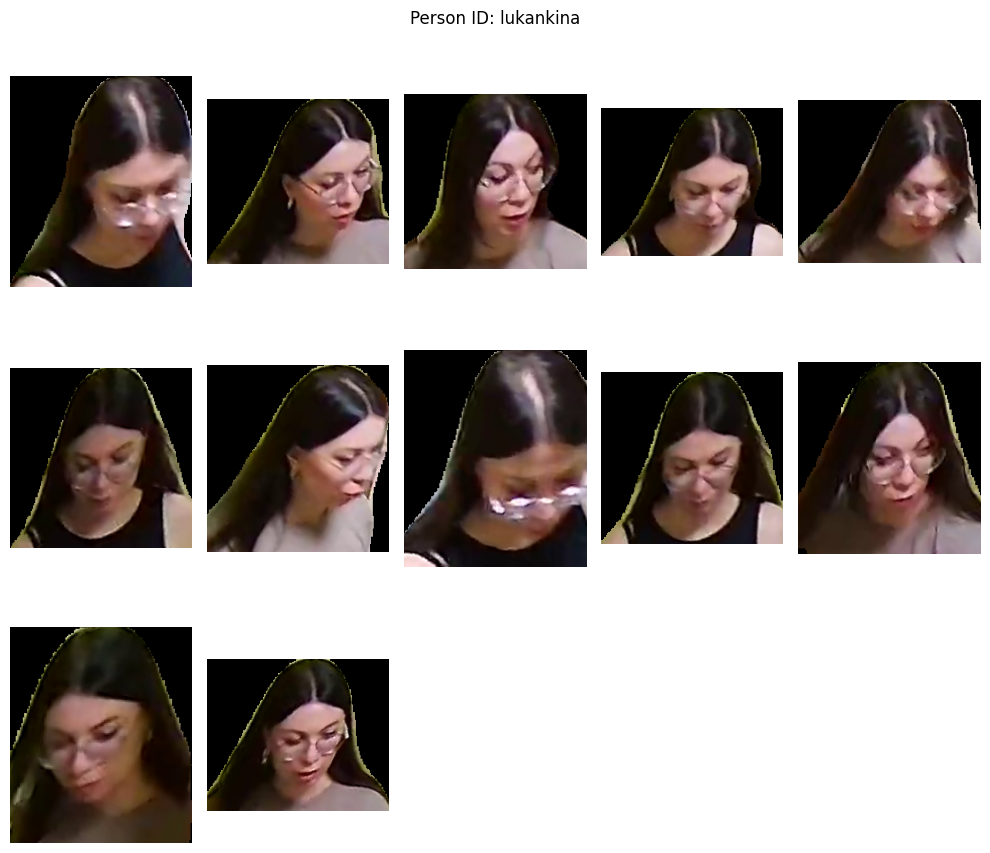

In [6]:
person_id = random.choice(os.listdir(DATASET))
folder_path = os.path.join(DATASET, person_id)
logger.info(f'Samples from {os.path.basename(DATASET)}')
visualize_sample_images(folder_path)

# Siamese Neural Network

## Generating Triplets

In [7]:
def triplets(folder_paths, max_triplets=7):
    anchor_images = []
    positive_images = []
    negative_images = []

    for person_folder in folder_paths:
        images = [os.path.join(person_folder, img)
                  for img in os.listdir(person_folder)]
        num_images = len(images)

        if num_images < 2:
            continue

        random.shuffle(images)

        for _ in range(max(num_images-1, max_triplets)):
            anchor_image = random.choice(images)

            positive_image = random.choice([x for x in images
                                            if x != anchor_image])

            negative_folder = random.choice([x for x in folder_paths
                                             if x != person_folder])

            negative_image = random.choice([os.path.join(negative_folder, img)
                                            for img in os.listdir(negative_folder)])

            anchor_images.append(anchor_image)
            positive_images.append(positive_image)
            negative_images.append(negative_image)

    return anchor_images, positive_images, negative_images

In [8]:
person_folders = [os.path.join(DATASET.as_posix(), folder_name) for folder_name in os.listdir(DATASET)]
anchors, positives, negatives = triplets(person_folders)

## Splitting Triplets

In [9]:
def split_triplets(anchors_, positives_, negatives_, validation_split=0.2):
    triplets = list(zip(anchors_, positives_, negatives_))
    train_triplets, val_triplets = train_test_split(triplets, test_size=validation_split, random_state=42)
    return train_triplets, val_triplets

In [10]:
train_triplets, val_triplets = split_triplets(anchors, positives, negatives)
len(train_triplets), len(val_triplets)

(52, 13)

## Loading and Preprocessing Images

In [11]:
def load_and_preprocess_image(image_path, expand_dims=False):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))
    if expand_dims:
        image = np.expand_dims(image, axis=0)
    return image

## Batch Generator with Data Augmentation

In [12]:
def batch_generator(triplets_, batch_size=32, augment=True):
    total_triplets = len(triplets_)
    random_indices = list(range(total_triplets))
    random.shuffle(random_indices)
    
    datagen = ImageDataGenerator(
        rotation_range=10,  
        width_shift_range=0.05, 
        height_shift_range=0.05,   
        horizontal_flip=True,
        zoom_range=0.2
    )
    
    for i in range(0, total_triplets, batch_size):
        batch_indices = random_indices[i:i + batch_size]
        batch_triplets = [triplets_[j] for j in batch_indices]

        anchor_batch = []
        positive_batch = []
        negative_batch = []

        for triplet in batch_triplets:
            anchor, positive, negative = triplet
            
            anchor_image = load_and_preprocess_image(anchor)
            positive_image = load_and_preprocess_image(positive)
            negative_image = load_and_preprocess_image(negative)
                
            if augment:
                anchor_image = datagen.random_transform(anchor_image)
                positive_image = datagen.random_transform(positive_image)
                negative_image = datagen.random_transform(negative_image)

            anchor_batch.append(anchor_image)
            positive_batch.append(positive_image)
            negative_batch.append(negative_image)

        yield [np.array(anchor_batch),
               np.array(positive_batch),
               np.array(negative_batch)]

## Visualizing Triplets

In [13]:
def visualize_triplets(triplets):
    anchor_batch, positive_batch, negative_batch = triplets

    for i in range(len(anchor_batch)):
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.title("Anchor")
        plt.imshow(anchor_batch[i])
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Positive")
        plt.imshow(positive_batch[i])
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Negative")
        plt.imshow(negative_batch[i])
        plt.axis('off')

        plt.show()

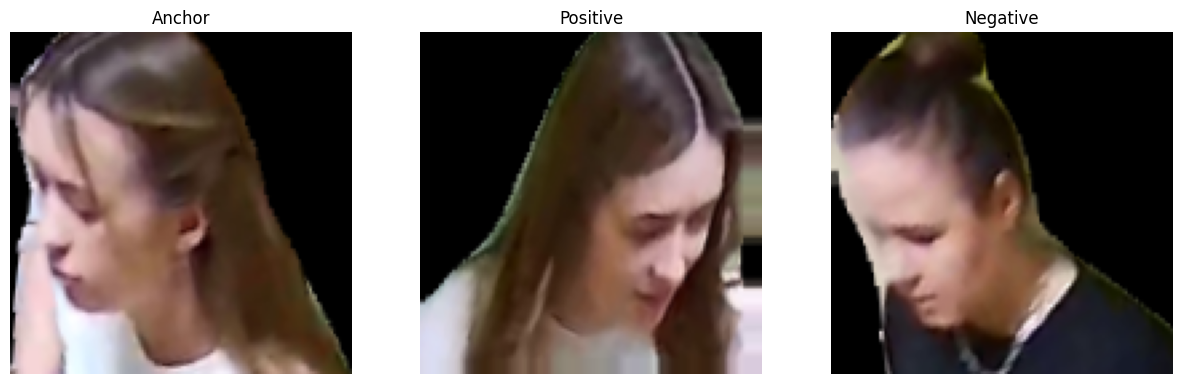

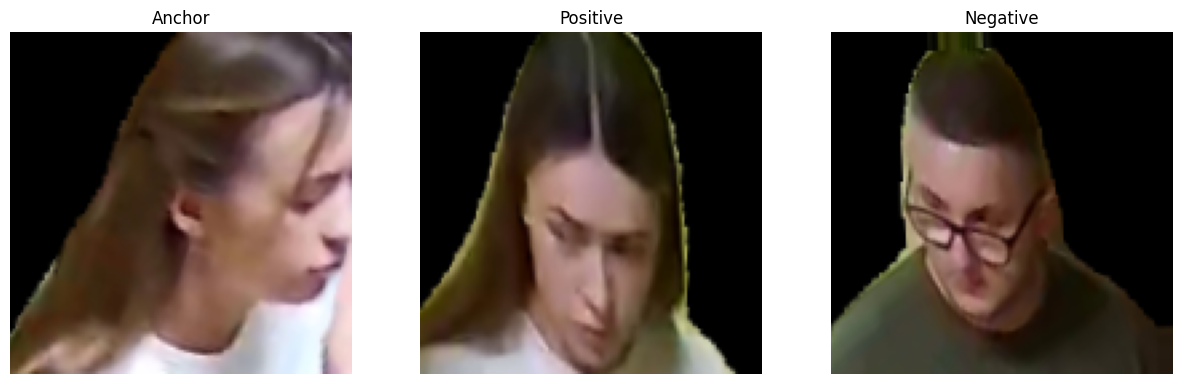

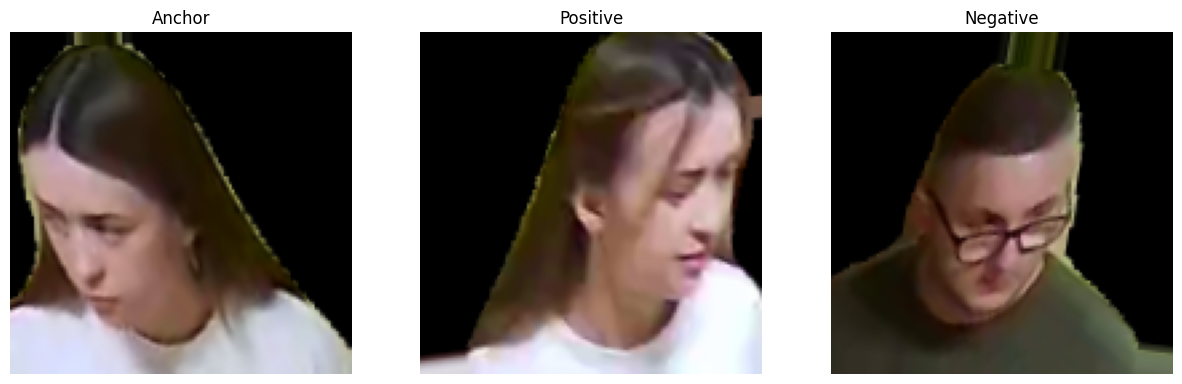

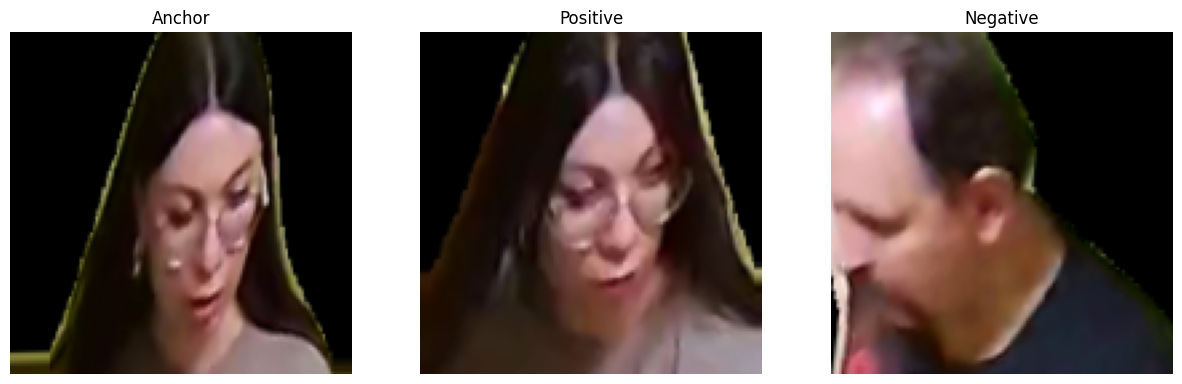

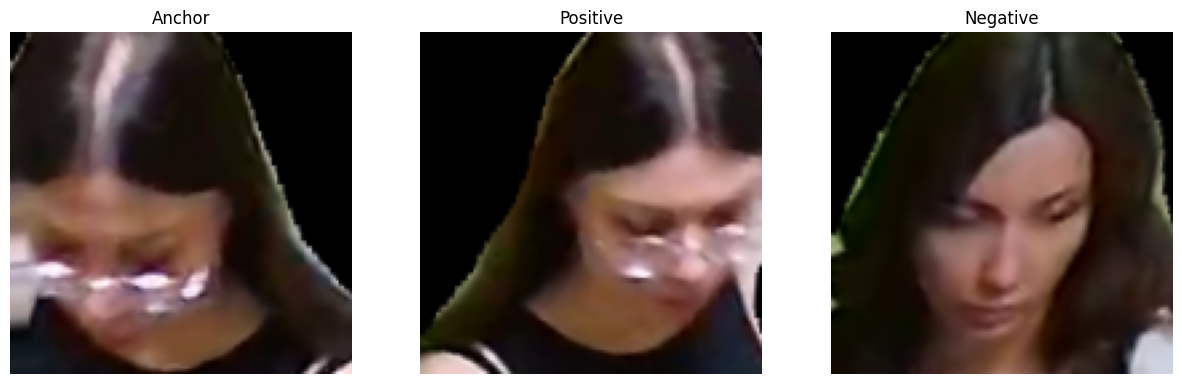

In [14]:
example_triplets = [next(batch_generator(train_triplets, 5))]
visualize_triplets(example_triplets[0])

## Defining the Embedding Model

In [15]:
def get_embedding(input_shape, num_layers_to_unfreeze=25):
    base_model = EfficientNetB7(weights='imagenet',
                                input_shape=input_shape,
                                include_top=False,
                                pooling='avg')

    for i in range(len(base_model.layers)-num_layers_to_unfreeze):
        base_model.layers[i].trainable = False

    embedding = tf.keras.models.Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(128)
    ], name='Embedding')

    return embedding

In [16]:
input_shape = (128, 128, 3)
embedding = get_embedding(input_shape)
embedding.summary()

Model: "Embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ ?                      │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,097,687 (244.51 MB)

 Trainable params: 10,919,840 (41.66 MB)

 Non-trainable params: 53,177,847 (202.86 MB)

## Siamese Network Architecture

In [17]:
@tf.keras.utils.register_keras_serializable()
class DistanceLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor_, positive_, negative_):
        ap_distance = tf.reduce_sum(tf.square(anchor_ - positive_), -1)
        an_distance = tf.reduce_sum(tf.square(anchor_ - negative_), -1)
        return ap_distance, an_distance

anchor_input = Input(name='anchor', shape=input_shape)
positive_input = Input(name='positive', shape=input_shape)
negative_input = Input(name='negative', shape=input_shape)

distances = DistanceLayer()(
    embedding(preprocess_input(anchor_input)),
    embedding(preprocess_input(positive_input)),
    embedding(preprocess_input(negative_input))
)

siamese_net = Model(
    inputs=[anchor_input,
            positive_input,
            negative_input],
    outputs=distances
)

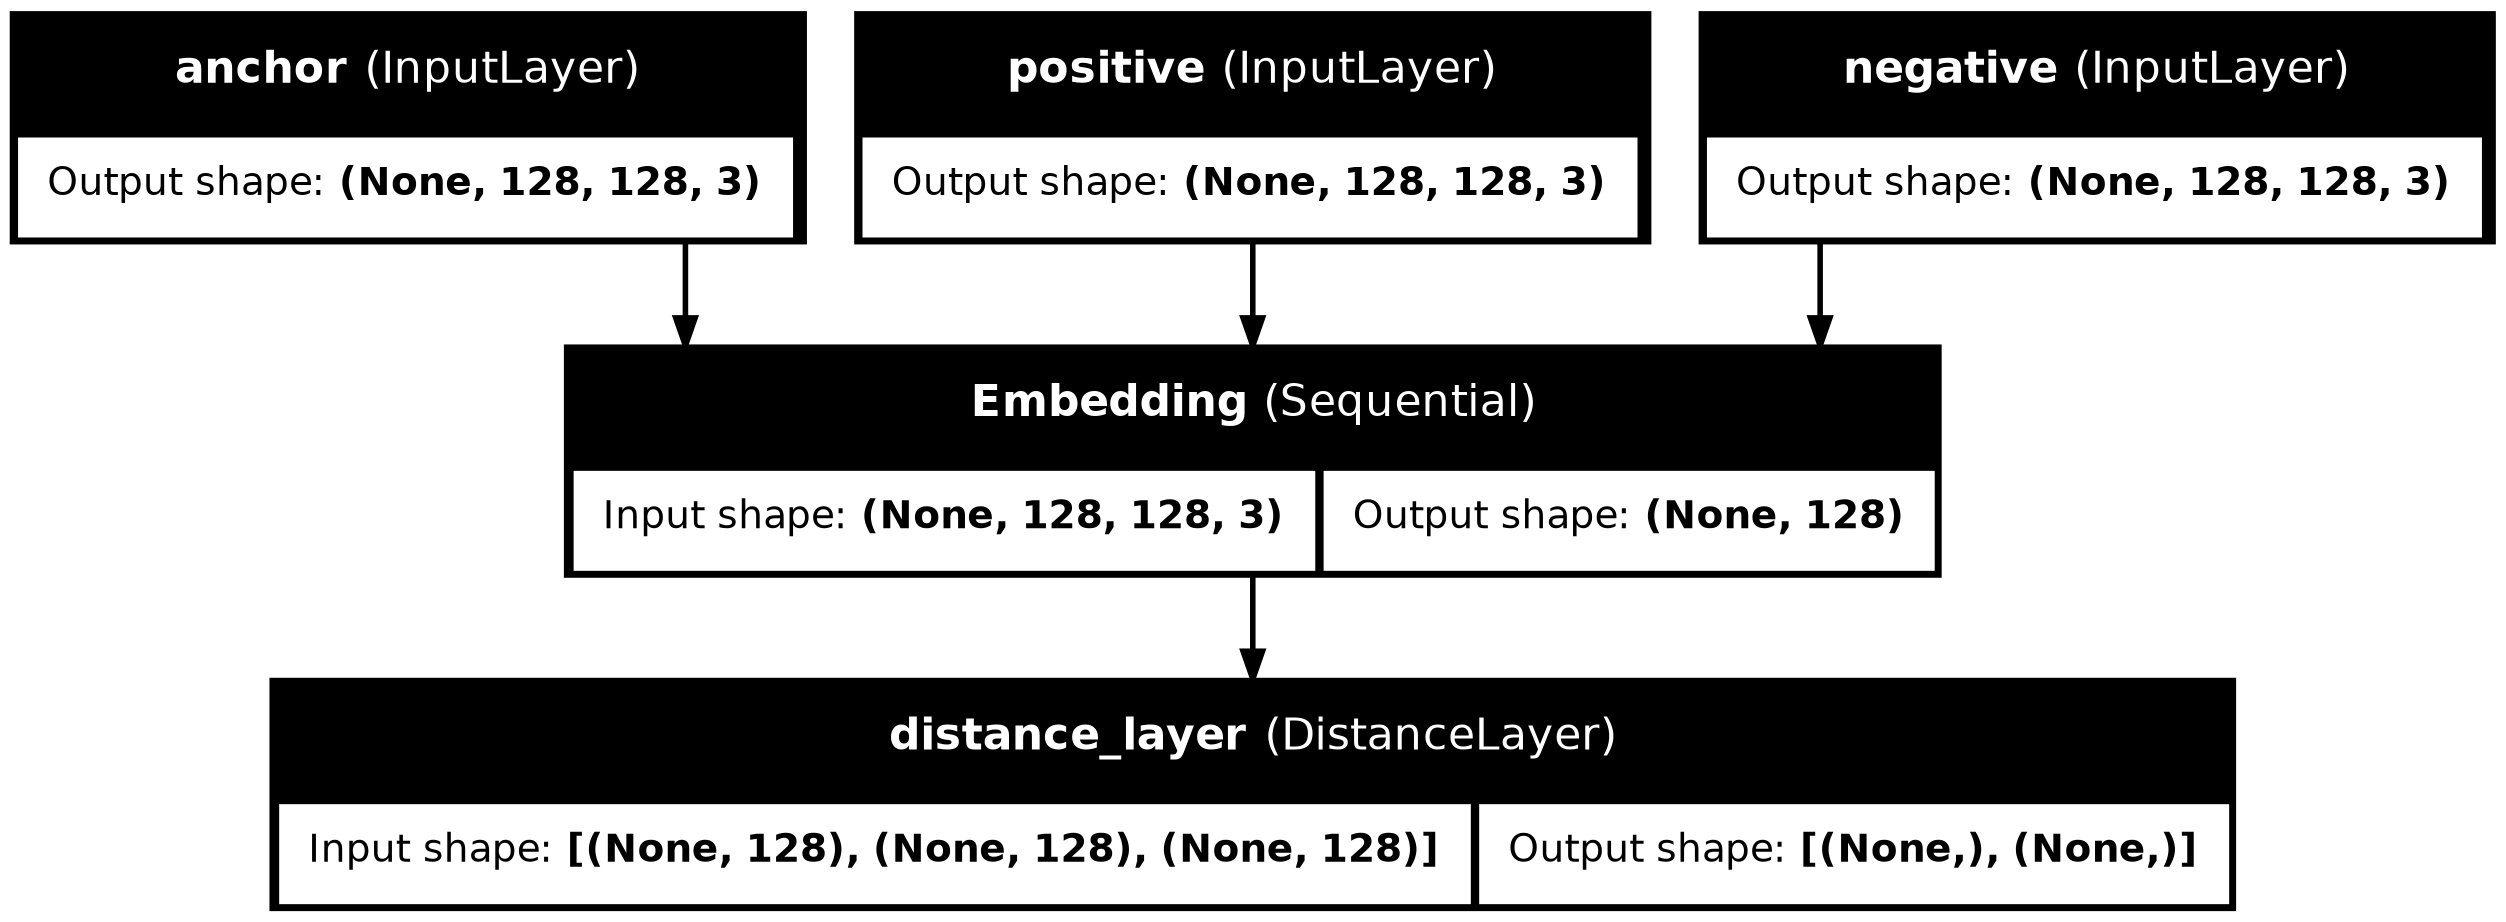

In [18]:
plot_model(siamese_net, show_shapes=True, show_layer_names=True)

In [19]:
siamese_net.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ anchor (InputLayer) │ (None, 128, 128,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positive            │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ negative            │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Embedding           │ (None, 128)       │ 65,593,239 │ anchor[0][0],     │
│ (Sequential)        │                   │            │ positive[0][0],   │
│                     │                   │            │ negative[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distance_layer      │ [(None), (None)]  │          0 │ Embedding[0][0],  │
│ (DistanceLayer)     │                   │            │ Embedding[1][0],  │
│                     │                   │            │ Embedding[2][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 65,593,239 (250.22 MB)

 Trainable params: 12,413,600 (47.35 MB)

 Non-trainable params: 53,179,639 (202.86 MB)

## Custom Siamese Model

In [20]:
@tf.keras.utils.register_keras_serializable()
class SiameseModel(Model):
    def __init__(self, siamese_net, margin=0.5):
        super().__init__()
        self.siamese_net = siamese_net
        self.margin = margin
        self.loss_tracker = Mean(name='loss')
        self.accuracy_tracker = Mean(name='accuracy')

    def call(self, inputs):
        return self.siamese_net(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_net.trainable_weights)

        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_net.trainable_weights)
        )

        self.loss_tracker.update_state(loss)

        accuracy = self._compute_accuracy(data)
        self.accuracy_tracker.update_state(accuracy)

        return {'loss': self.loss_tracker.result(),
                'accuracy': self.accuracy_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)

        accuracy = self._compute_accuracy(data)
        self.accuracy_tracker.update_state(accuracy)

        return {'loss': self.loss_tracker.result(),
                'accuracy': self.accuracy_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_net(data)

        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, .0)
        return loss

    def _compute_accuracy(self, data):
        ap_distance, an_distance = self.siamese_net(data)
        accuracy = tf.reduce_mean(tf.cast(ap_distance < an_distance,
                                          tf.float32))
        return accuracy

    @property
    def metrics(self):
        return [self.loss_tracker, self.accuracy_tracker]

    def get_config(self):
        base_config = super().get_config()
        config = {
            'siamese_net': tf.keras.saving.serialize_keras_object(self.siamese_net),
            'margin': tf.keras.saving.serialize_keras_object(self.margin),
            'loss_tracker': tf.keras.saving.serialize_keras_object(self.loss_tracker),
            'accuracy_tracker': tf.keras.saving.serialize_keras_object(self.accuracy_tracker),
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        config['siamese_net'] = tf.keras.saving.deserialize_keras_object(config.pop('siamese_net'))
        config['margin'] = tf.keras.saving.deserialize_keras_object(config.pop('margin'))
        config['loss_tracker'] = tf.keras.saving.deserialize_keras_object(config.pop('loss_tracker'))
        config['accuracy_tracker'] = tf.keras.saving.deserialize_keras_object(config.pop('accuracy_tracker'))
        return cls(**config)

## Training the Siamese Model

In [21]:
def train_model(model, train_triplets, epochs, batch_size, val_triplets, patience, delta=0.0001):
    best_val_accuracy = 0
    best_val_loss = float('inf')
    temp_patience = patience
    history = {
        'loss': [],
        'val_loss': [],
        'accuracy': [],
        'val_accuracy': []
    }

    train_steps_per_epoch = math.ceil(len(train_triplets) / batch_size)
    val_steps_per_epoch = math.ceil(len(val_triplets) / batch_size)

    for epoch in range(epochs):
        logger.info(f'Epoch {epoch+1}/{epochs}')
        train_loss = 0.
        train_accuracy = 0.
        val_loss = 0.
        val_accuracy = 0.

        with tqdm(total=train_steps_per_epoch, desc='Training') as pbar:
            for batch in batch_generator(train_triplets, batch_size=batch_size):
                loss, accuracy = model.train_on_batch(batch)
                train_loss += loss
                train_accuracy += accuracy

                pbar.update()
                pbar.set_postfix({'Loss': loss, 'Accuracy': accuracy})

        with tqdm(total=val_steps_per_epoch, desc='Validation') as pbar:
            for batch in batch_generator(val_triplets, batch_size=batch_size):
                loss, accuracy = model.test_on_batch(batch)
                val_loss += loss
                val_accuracy += accuracy

                pbar.update()
                pbar.set_postfix({'Loss': loss, 'Accuracy': accuracy})

        train_loss /= train_steps_per_epoch
        train_accuracy /= train_steps_per_epoch
        val_loss /= val_steps_per_epoch
        val_accuracy /= val_steps_per_epoch

        history['loss'].append(train_loss)
        history['accuracy'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        logger.success(f'\nTrain Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        logger.success(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}\n')

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            model.layers[0].layers[3].save_weights('best_model.weights.h5')

        if val_loss - best_val_loss > delta:
            temp_patience -= 1
            if temp_patience == 0:
                print('Early stopping: Validation loss did not improve.')
                break
        else:
            best_val_loss = val_loss
            temp_patience = patience

    return model, history


## Training

In [ ]:
siamese_model = SiameseModel(siamese_net)
siamese_model.compile(optimizer=Adam(0.001))

siamese_model, history = train_model(
    siamese_model, train_triplets=train_triplets, epochs=200, batch_size=128, val_triplets=val_triplets, patience=3)

In [ ]:
# Save the model
siamese_model.save('siamese_model.h5')

In [ ]:
# Load the model
# model = tf.keras.models.load_model('siamese_model.h5')

# Model Evaluation

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')

plt.subplot(122)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')

plt.show()

## Calculating Cosine Similarity

In [ ]:
sample = next(batch_generator(val_triplets, 1))

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(preprocess_input(anchor)),
    embedding(preprocess_input(positive)),
    embedding(preprocess_input(negative))
)

cosine_similarity = CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print(f'Positive similarity: {positive_similarity}')

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print(f'Negative similarity: {negative_similarity}')